To complete Task 2, I choose to use the platform Pennylane together with the visualisation package in Qiskit.

In [3]:
import pennylane as qml
import torch
from torch.autograd import Variable
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import numpy as np

We create the four random input states and define the desired output probability distribution.

In [4]:
#set seed
np.random.seed(42)

#create four random vectors stored in a 2D array
in_states = np.random.normal(0,1,(4,16))
for i in range(len(in_states)):
    in_states[i] = in_states[i]/np.sqrt(np.sum(in_states[i]**2))
    
in_states = Variable(torch.tensor(in_states), requires_grad=False)

#create the target states:
target = np.zeros((4,16))
target[0][12] = 1
target[1][10] = 1
target[2][5] = 1
target[3][3] = 1

target = Variable(torch.tensor(target), requires_grad=False)

A layer of the circuit ansatz consists of two parts: general rotations on each qubit followed by and entangling layer.

In [5]:
# number of qubits in the circuit
nr_qubits = 4
# number of layers in the circuit
nr_layers = 3

# a layer of the circuit ansatz
def layer(params, j):
    for i in range(nr_qubits):
        qml.RX(params[i, j, 0], wires=i)
        qml.RY(params[i, j, 1], wires=i)
        qml.RZ(params[i, j, 2], wires=i)
        #qml.RY(params[i, j, 3], wires=i)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[1, 3])
    qml.CNOT(wires=[2, 3])

Further, we define the quantum circuit node in Pennylane. The circuit function takes two parameters: the params array, containing the parameters for the ansatz, and an initial state. We initiate the circuit in this state and then apply multiple layers of the previously defined ansatz. Finally we return the measurement probabilities on each qubit.

In [6]:
dev = qml.device("default.qubit", wires=nr_qubits)

@qml.qnode(dev, interface = "torch")
def circuit(params, initial_state):
    
    qml.QubitStateVector(initial_state, wires = range(nr_qubits))
    
    # repeatedly apply each layer in the circuit
    for j in range(nr_layers):
        layer(params, j)

    # return the measurement probabilities on each qubit
    return qml.probs(wires = range(nr_qubits))

Now that we have built the circuit, we need to define a cost function to update the parameters in the circuit in an optimization routine. Inspired by the article in the comment I choose a negative log-likelyhood function. Let $D$ be the set of tuples of 2 elements $(s,t)$, where $|s>$ is a randomly generated state and |t> is its specific target state. When the initial state is |s>, the ansatz produces the state $|\phi_s({\theta})>$, where ${\theta}$ is the parameter vector. Let $P_{{\theta}}(s,t)=|<t|\phi_s({\theta})>|^2$. The the cost that needs to be minimised is:
$$C(\theta) = -\frac{1}{|D|}\sum_{(s,t)\in D}P_{{\theta}}(s,t)$$

In [7]:
#define the negative log-likelihood cost, https://www.nature.com/articles/s41534-019-0157-8
def cost(params):
    cost = 0
    probs = [circuit(params, in_states[i]) for i in range(4)]
    l = len(probs)
    for i in range(l):
        cost -= 1/l*torch.log(torch.dot(probs[i],target[i]))
    return cost

We now optimize the parameters to minimise the cost function. We use an ADAM optimization routine nad initiate the parameters from a normal distribution.

In [8]:
# randomly initialize parameters from a normal distribution
params = np.random.normal(0, np.pi, (nr_qubits, nr_layers, 3))
params = Variable(torch.tensor(params), requires_grad=True)

# set up the optimizer
opt = torch.optim.Adam([params], lr=0.1)

# number of steps in the optimization routine
steps = 200

best_cost = cost(params)
best_params = np.zeros((nr_qubits, nr_layers, 3))

print("Cost after 0 steps is {:.4f}".format(cost(params)))

# optimization begins
for n in range(steps):
    opt.zero_grad()
    loss = cost(params)
    loss.backward()
    opt.step()

    # keeps track of best parameters
    if loss < best_cost:
        best_cost = loss
        best_params = params

    # Keep track of progress every 10 steps
    if n % 10 == 9 or n == steps - 1:
        print("Cost after {} steps is {:.4f}".format(n + 1, loss))


Cost after 0 steps is 2.8107
Cost after 10 steps is 1.3783
Cost after 20 steps is 1.0918
Cost after 30 steps is 0.8979
Cost after 40 steps is 0.7620
Cost after 50 steps is 0.6229
Cost after 60 steps is 0.6044
Cost after 70 steps is 0.5739
Cost after 80 steps is 0.5583
Cost after 90 steps is 0.5574
Cost after 100 steps is 0.5564
Cost after 110 steps is 0.5557
Cost after 120 steps is 0.5556
Cost after 130 steps is 0.5555
Cost after 140 steps is 0.5554
Cost after 150 steps is 0.5554
Cost after 160 steps is 0.5554
Cost after 170 steps is 0.5554
Cost after 180 steps is 0.5554
Cost after 190 steps is 0.5554
Cost after 200 steps is 0.5554


To check if the circuit produces the required result, we look at the output state of the optimised circuit when we initiate it with the randomly generated states. We visualise the results in a histogram.

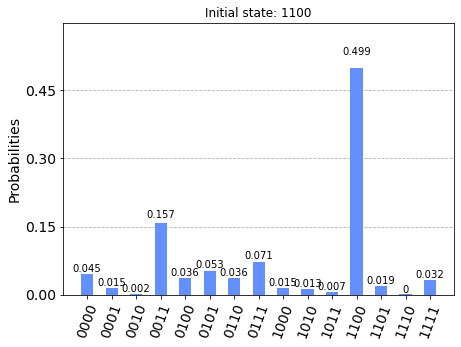

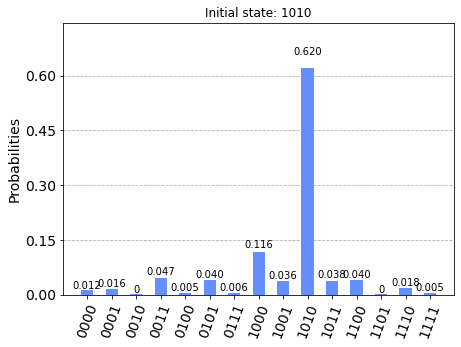

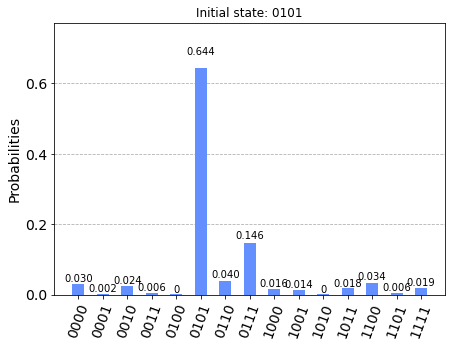

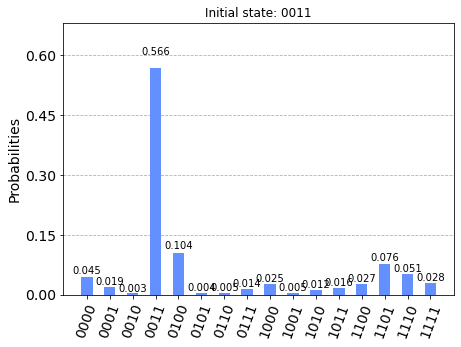

In [17]:
states = [Statevector(np.sqrt(circuit(best_params, in_states[i]).detach().numpy())) for i in range(4)]
strings = ['1100', '1010', '0101', '0011']
for i in range(4):
    display(plot_histogram(states[i].sample_counts(1024), title = "Initial state: "+strings[i]))

As it can be seen, the circuit amplifies the required basis states. If the starting states are not orthogonal, then there is no unitary $U$ that can achieve the required result, as unitary transformations preserve the scalar product and the end states are orthogonal. A non-reversible ansatz could achieve this by using intermediate ancilla measurements between layers. 